In [ ]:
#Input file can be found at following location
#https://drive.google.com/file/d/0B6uUAXinoeZBZF9VRFlGOHVHMnc/view?usp=sharing

In [1]:
#Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Load Input File 
#File contains information regarding flight delays for January, June, July, August, November, December month of 2016
path = 'F:\\Study\\OneDrive - The University of Texas at Dallas\\02 Study\\12 Startup.ML\\Files\\Input_File\\'
path_file = path+'flight_data.csv'
flight_data = pd.read_csv(path_file)
 

In [3]:
flight_data.head()


,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,...,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,Unnamed: 42
0,1,1,3,7,2016-01-03,F9,694,11292,1129202,30325,...,87.0,1.0,692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,3,7,2016-01-03,F9,809,14027,1402702,34027,...,224.0,1.0,1679.0,19.0,0.0,0.0,0.0,0.0,NaN,NaN
2,1,1,3,7,2016-01-03,F9,907,15356,1535602,35356,...,60.0,1.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,3,7,2016-01-03,F9,908,14492,1449202,34492,...,57.0,1.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,3,7,2016-01-03,F9,915,15356,1535602,35356,...,107.0,1.0,693.0,2.0,0.0,18.0,0.0,0.0,NaN,NaN


In [4]:
print(flight_data.shape)

(2846155, 43)


In [6]:
#Create a Variable called Delayed, Flight is considered to be delayed if arrival delay is more than or equal to 15 minutes
flight_data['Delayed'] = np.where(flight_data['ARR_DELAY'] >=15, 1,0)

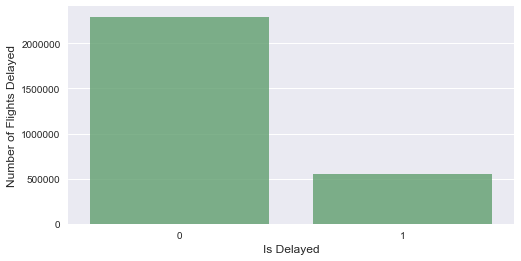

In [15]:
#Distribution of Number of flights Delayed
is_delayed = flight_data['Delayed'].value_counts()

plt.figure(figsize=(8,4))
color = sns.color_palette()
sns.barplot(is_delayed.index, is_delayed.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Flights Delayed', fontsize=12)
plt.xlabel('Is Delayed', fontsize=12)
plt.show()



In [16]:
#percentage of flights delayed (arrival time more than or equal to 15minutes)
print (flight_data['ARR_DELAY'][flight_data['ARR_DELAY'] >= 15].count())
print (flight_data.shape[0] - flight_data.CARRIER_DELAY.isnull().sum().sum())
flight_delay =flight_data['ARR_DELAY'][flight_data['ARR_DELAY'] >= 15].count()/flight_data.shape[0]
print("Percentage of Flights Delayed for More Than 15 Minutes:  {:.2%}".format(flight_delay))

550729
550729
Percentage of Flights Delayed for More Than 15 Minutes:  19.35%


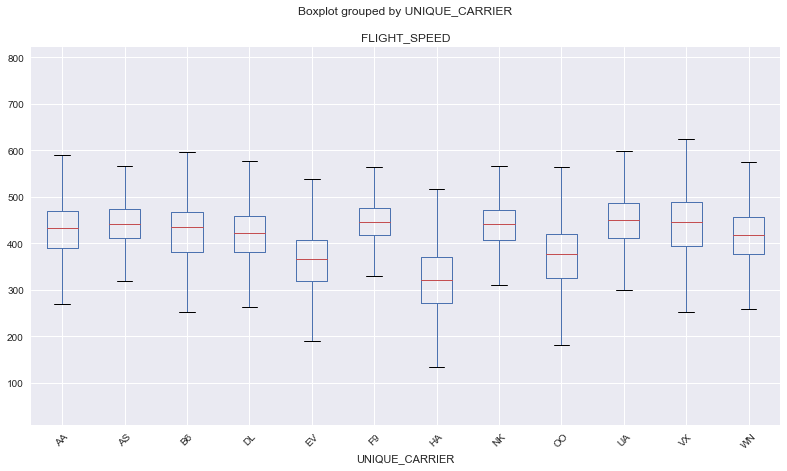

In [4]:
#Data Exploration
#Distribution of flight speed as speed of aircraft can cause arrival delay 
flight_data['FLIGHT_SPEED'] = 60*flight_data['DISTANCE']/flight_data['AIR_TIME']
flight_data[['UNIQUE_CARRIER','FLIGHT_SPEED']].boxplot(column = 'FLIGHT_SPEED',by='UNIQUE_CARRIER',figsize=(13,7),rot=45)

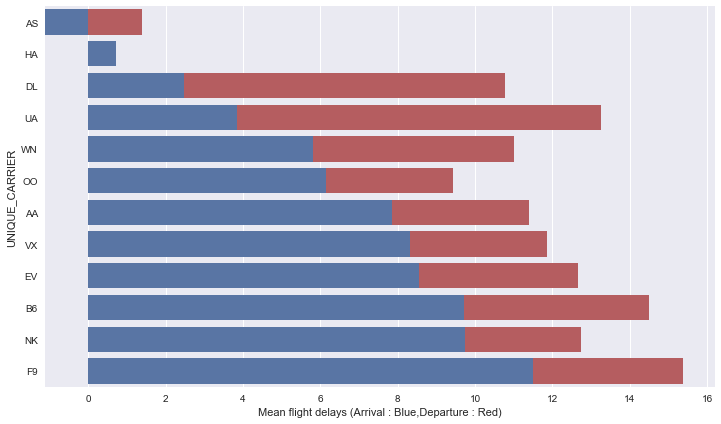

In [26]:
#Arrival and Departure Delay
df_delay = pd.DataFrame(flight_data.groupby('UNIQUE_CARRIER')[['ARR_DELAY','DEP_DELAY']].mean())
df_delay.sort_values(['ARR_DELAY','DEP_DELAY'],ascending = [1,1],inplace=True)
plt.figure(figsize=(12,7))
sns.set_color_codes("deep")
sns.set_context(font_scale=2.5)
plot = sns.barplot(x='DEP_DELAY',y=df_delay.index,data = df_delay,color = 'r')
plot = sns.barplot(x='ARR_DELAY',y=df_delay.index,data = df_delay,color = 'b')
plot.set(xlabel='Mean flight delays (Arrival : Blue,Departure : Red)')

In [7]:
#Filter data for model building
flight_data_filtered = flight_data[['MONTH', 'DAY_OF_MONTH', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME','Delayed', 'CRS_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE']]
print("Shape of Flight data with null values: ",flight_data_filtered.shape)
#Drop null values from the data
flight_data_filtered = flight_data_filtered.dropna()
print("Shape of flight data without null values:", flight_data_filtered.shape)
flight_data_filtered_dummy = pd.get_dummies(flight_data_filtered)
flight_data_shuffle = shuffle(flight_data_filtered_dummy)
flight_data_shuffle.shape


Shape of Flight data with null values:  (2846155, 14)
Shape of flight data without null values: (2796517, 14)


(2796517, 25)

In [25]:
#Split data into test and train dataset
y = flight_data_shuffle['Delayed']
x = flight_data_shuffle.drop('Delayed',1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [26]:
print("Training Dataset independent vairable:",X_train.shape)
print("Training Dataset dependent vairable:",y_train.shape)
print("Test Dataset independent vairable:",X_test.shape)
print("Test Dataset dependent vairable:",y_test.shape)

Training Dataset independent vairable: (2237213, 24)
Training Dataset dependent vairable: (2237213,)
Test Dataset independent vairable: (559304, 24)
Test Dataset dependent vairable: (559304,)


# New Approach: models are built using different approaches as follows 
    
    1. Iterative Approach : data is passed in chunks to the logistic regressor (approach previously used)
    2. By using full dataset
    3. Last 1000 records
    4. len(dataset) -2000 to len(dataset) - 1000 records
    5. In between 1000 records (starting number is choosen randomly)

In [29]:
#Train Logistic Model

#With Iterative apporach
logistic = LogisticRegression()
count = 0
model_iteraction = 0
while count < len(X_train):
    test_data_x = X_train[count:count+1000]
    test_data_y = y_train[count:count+1000]
    count = count + 1000
    #print("Training Model iteration "+str(model_iteraction))
    logistic.fit(test_data_x,test_data_y)
    model_iteraction +=1
    
print("Iterative Model Training Done!") 

final_logistic = logistic.predict(X_test)
final_logistic = pd.DataFrame(final_logistic)
matrix = confusion_matrix(y_test, final_logistic)
print("Confusion Matrix:\n",matrix)
print("Accuracy Score with iterative approach: ",accuracy_score(y_test,final_logistic))

Iterative Model Training Done!
Confusion Matrix:
 [[431023  17923]
 [ 25402  84956]]
Accuracy Score with iterative approach:  0.922537653941


In [30]:
# With Full Dataset
logistic_full = LogisticRegression()
logistic_full.fit(X_train,y_train)    
print("Full Data Model Training Done!")  


final_logistic = logistic_full.predict(X_test)
final_logistic = pd.DataFrame(final_logistic)
matrix = confusion_matrix(y_test, final_logistic)
print("Confusion Matrix:\n",matrix)
print("Accuracy Score with full dataset: ",accuracy_score(y_test,final_logistic))

Full Data Model Training Done!
Confusion Matrix:
 [[448368    578]
 [ 89992  20366]]
Accuracy Score with full dataset:  0.838066597056


In [31]:
#Last 1000 records
logistic_1000 = LogisticRegression()
test_data_x = X_train[2236213:]
test_data_y = y_train[2236213:]
logistic_1000.fit(test_data_x,test_data_y)
    
print("last 1000 Model Training Done!") 

final_logistic = logistic_1000.predict(X_test)
final_logistic = pd.DataFrame(final_logistic)
matrix = confusion_matrix(y_test, final_logistic)
print("Confusion Matrix:\n",matrix)
print("Accuracy Score with last 1000 approach: ",accuracy_score(y_test,final_logistic))


#Last 2000 records
logistic_2000 = LogisticRegression()
test_data_x = X_train[2235213:2236213]
test_data_y = y_train[2235213:2236213]
logistic_2000.fit(test_data_x,test_data_y)
    
print("last 2000 Model Training Done!") 

final_logistic = logistic_2000.predict(X_test)
final_logistic = pd.DataFrame(final_logistic)
matrix = confusion_matrix(y_test, final_logistic)
print("Confusion Matrix:\n",matrix)
print("Accuracy Score with last 2000 approach: ",accuracy_score(y_test,final_logistic))




last 1000 Model Training Done!
Confusion Matrix:
 [[443486   5460]
 [ 44878  65480]]
Accuracy Score with last 1000 approach:  0.909998855721
last 2000 Model Training Done!
Confusion Matrix:
 [[448440    506]
 [103971   6387]]
Accuracy Score with last 2000 approach:  0.813201765051


In [33]:
#another 1000 records
logistic_random = LogisticRegression()
test_data_x = X_train[2225213:2226213]
test_data_y = y_train[2235213:2236213]
logistic_random.fit(test_data_x,test_data_y)
    
print("last 2000 Model Training Done!") 

final_logistic = logistic_2000.predict(X_test)
final_logistic = pd.DataFrame(final_logistic)
matrix = confusion_matrix(y_test, final_logistic)
print("Confusion Matrix:\n",matrix)
print("Accuracy Score with random 1000 approach: ",accuracy_score(y_test,final_logistic))

last 2000 Model Training Done!
Confusion Matrix:
 [[448440    506]
 [103971   6387]]
Accuracy Score with random 1000 approach:  0.813201765051


In [34]:
#Iterative approach with 10000 records
logistic_10000 = LogisticRegression()
count = 0
model_iteraction = 0
while count < len(X_train):
    test_data_x = X_train[count:count+10000]
    test_data_y = y_train[count:count+10000]
    count = count + 10000
    #print("Training Model iteration "+str(model_iteraction))
    logistic_10000.fit(test_data_x,test_data_y)
    model_iteraction +=1
    
print("Iterative Model-10000 Training Done!") 

final_logistic = logistic_10000.predict(X_test)
final_logistic = pd.DataFrame(final_logistic)
matrix = confusion_matrix(y_test, final_logistic)
print("Confusion Matrix:\n",matrix)
print("Accuracy Score with iterative approach- 10000: ",accuracy_score(y_test,final_logistic))

Iterative Model-10000 Training Done!
Confusion Matrix:
 [[447495   1451]
 [ 96871  13487]]
Accuracy Score with iterative approach- 10000:  0.82420651381
